<a href="https://colab.research.google.com/github/2022tumoresferas/AyVD/blob/main/1_Analisis_y_Visualizacion_Clasificacion_Tumoresferas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
 <h2>Mentoría: Clasificación de Tumoresferas </h2>
</center>



<a name="exploratory_data_analysis"></a>
#### **Práctico de Análisis Exploratorio y Visualización**

*FECHA LíMITE DE ENTREGA: 20/05*

### Descripción de los datos: 

Se tratan de datos procesados en el [Grupo de Materia Condensada](https://ri.conicet.gov.ar/handle/11336/102) (FaMAF-UNC, IFEG-CONICET) en colaboración con el Laboratorio de Células Madre del [IBYME-CONICET](https://www.ibyme.org.ar/laboratorios/49/celulas-madre) a partir de imágenes tomadas usando un microscopio óptico invertido común.


Para extraer la información estructurada a partir de las imágenes se hizo uso del programa Fiji, que es un paquete de procesamiento de imágenes, distribución muy completa del programa [ImageJ](https://www.medicinatv.com/profesional/reportajes/una-plataforma-abierta-revoluciona-el-procesamiento-de-imagenes-biomedicas-4596/), que es ampliamente utilizado para procesar
imágenes médicas. 

De acuerdo a la documentación del programa,
es posible contar y medir objetos si conocemos la escala en la cual se han
llevado a cabo dichas imágenes, en este caso, a cuántos $\mu$m equivale un
píxel.
Para llevar a cabo el procedimiento detallado en la [documentación](https://imagej.nih.gov/ij/docs/guide/146-30.html#sub:Analyze-Particles...),
es necesario contar con una imagen umbralizada. 

Se realizó este procedimiento en las 91 imágenes disponibles y se etiquetaron en *esferoides* 'si' y 'no' de acuerdo al criterio de un [experto](https://www.conicet.gov.ar/new_scp/detalle.php?id=43977&datos_academicos=yes), obteniendo 1018 datos.



Para asociar el Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
try:
  import os
  os.chdir("/content/drive/My Drive/Datos_tumoresferas")
  # para acceder a la carpeta, en el siguiente link:
  # https://drive.google.com/drive/folders/1RqGNySwACN33Qopmw0nHmj5Yv4M78ZXi?usp=sharing
except FileNotFoundError:
  url = 'http://www.ccll.com.ar/fiji_datos_0al7mo_labels.csv'

In [3]:
# Ejemplo de una de las imágenes umbralizadas:
from IPython.display import Image

In [4]:
try:
  Image(filename="/content/drive/MyDrive/Datos_tumoresferas/ejemplo_segmentacion.png", width = 800, height = 300)
except FileNotFoundError:
  Image(url="http://www.ccll.com.ar/ejemplo_segmentacion.png", width = 800, height = 300)

Importamos las librerías necesarias:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk') 
# por si quieren ver los distintos formatos:
# https://datavizpyr.com/seaborn-set_context-to-adjust-size-of-plot-labels-and-lines/
# https://seaborn.pydata.org/generated/seaborn.set_context.html

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import kurtosis
import scipy.stats
import math

## Datos


Cargamos los datos de los experimentos realizados desde el día cero al séptimo. 


Ya se encuentran las etiquetas y el valor de las poblaciones celulares estimadas en cada esferoide.

In [6]:
try:
  fiji_datos = pd.read_csv("fiji_datos_0al7mo_labels.csv")
except FileNotFoundError:
  fiji_datos = pd.read_csv(url)

fiji_datos.head()

,labels,Area,X,Y,XM,YM,Perim.,BX,BY,Width,...,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Esferoide,dia,Diameter,n_diam
0,Esferas_BT474_dia_0_well_1_100X_1_blob_1,324.4440,1129.2718,102.2051,1129.2718,102.2051,67.3603,1118.8859,92.3913,21.0598,...,157,23.4287,19.7011,1.0653,0.9387,0.9500,si,0,20.95640,1.491357
1,Esferas_BT474_dia_0_well_1_100X_1_blob_2,497.5115,1517.5528,126.1022,1517.5528,126.1022,82.8004,1504.7554,113.4511,25.8152,...,192,16.1443,25.1289,1.0475,0.9546,0.9569,si,0,26.00200,2.848733
2,Esferas_BT474_dia_0_well_1_100X_1_blob_3,282.9078,1314.2815,126.0988,1314.2815,126.0988,62.1586,1304.3478,116.8478,19.7011,...,189,15.4222,18.3424,1.0395,0.9620,0.9519,si,0,19.38970,1.181258
3,Esferas_BT474_dia_0_well_1_100X_1_blob_5,500.7421,1189.2841,212.6155,1189.2841,212.6155,84.5571,1175.9511,200.4076,26.4946,...,309,174.1440,25.1359,1.0278,0.9730,0.9493,si,0,25.88475,2.810370
4,Esferas_BT474_dia_0_well_1_100X_1_blob_6,492.8964,1043.0782,247.7667,1043.0782,247.7667,82.0728,1030.5707,235.7337,25.1359,...,353,143.4270,24.4565,1.0186,0.9817,0.9643,si,0,25.33985,2.636596


#### Descripción de las columnas:

   * **labels** (*'nombre_id'*): etiqueta que indica la estructura segmentada seleccionada. 
   * **Area** (*'area'*): columna que indica el área de selección en $\mu$m$^2$.
   * **Perim.** (*'perimetro'*): Es la longitud  del límite exterior de la selección. 
   * **Width** (*'ancho'*) y **Height** (*'altura'*): Es el ancho y la altura del rectángulo mas pequeño que encierra la estructura seleccionada.
   * **Circ.** (*'circulalidad'*): Indica la *circularidad*. Se calcula como 4π × [Area]/[Perimeter]$^2$, que con un valor de 1.0 indica un círculo perfecto. A medida que se acerca a 0.0, indica una forma cada vez más alargada. 
   * Columnas del diámetro de Feret: 
       * **Feret** (*feret*): Indica la distancia más larga entre dos puntos a lo largo del límite de selección. 
       * **MinFeret** (*min_feret*): Indica la distancia mínima entre dos puntos a lo largo del límite de selección.
       * **FeretAngle**: Indica el ángulo del diámetro de Feret.
       * **FeretX** y **FeretY**: son las coordenadas iniciales del diámetro de Feret. 
       * **AR** (*razon_aspecto*): Indica la  razón de aspecto de la elipse ajustada de la estructura seleccionada, es decir, [Eje mayor]/[Eje menor].
       * **Round** (*redondez*): Se calcula como  (4 × [Area] )/ (π × [Major axis]^2) o como la inversa de **AR**. Tiene un rango entre 0 y 1, con 1 indicando un círculo perfecto.
       * **Solidity**: Se calcula como [Area]/[Convex area]. Se calcula el área convexa como el área de una banda elástica envuelta firmemente alrededor de los puntos que definen la selección.
       * **Esferoide** (*esferoide*): etiqueta que indica si la estructura seleccionada califica como esferoide o no
       * **dia**: etiqueta que indica el día en el cual fue realizada la fotografía de origen. 
       * **Diameter** (*diametro*): Se calculó como 0.5*(*Feret*+*MinFeret*)
       * **n_diam** (*poblacion_celular*) se calculó como $(D_n/D_0)^3$, teniendo en cuenta el diámetro mínimo a día 0 ($D_0$) y el diámetro $D_n$ a un tiempo posterior.

Como utilizamos las imágenes ya segmentadas y recortadas, las columnas *X*, *Y*, *XM*, *YM*, *BX*, *BY* no sirven para el análisis. Tampoco las coordenadas del diámetro de Feret (*FeretX* y *FeretY*) ni el ángulo (*FeretAngle*) ya que las estructuras se mueven mucho, no sirven como referencias. ¿Tiene sentido considerar en este caso la columna *Solidity*? 

Para mas información, pueden explorar la [documentación](https://imagej.nih.gov/ij/docs/guide/146-30.html#sub:Analyze-Particles...).


Pueden ver las imágenes crudas y las individuales (cada fila es una estructura) en la siguiente [carpeta compartida](https://drive.google.com/drive/folders/1aws02t4Z0wSrdbHsQ-cgBkwX8PKLU71c?usp=sharing).


# Análisis de los datos:

*   1) a) Explorar cuántos datos son, ¿cuáles son las columnas? Diferenciar entre categóricas y numéricas.
    
    b) De acuerdo a la descripción de las columnas, definir cuáles son las más importantes y descartar las columnas que no tienen mucha validez para el problema.

*   2) Cambiar el nombre de las columnas en inglés a castellano (están indicadas en paréntesis en la descripción).
*   3) Tratemos de responder alguna de las siguientes preguntas:
    * a) ¿Se trata de una muestra o población?
    * b) ¿Es más probable que sea esferoide o que no lo sea?

    * c) ¿La forma (área, circularidad, diámetro, redondez) influye en la clasificación de *Esferoide*? 
    
    * d) ¿Tales variables son independientes entre sí? 
    * e) ¿La probabilidad de que la redondez ('Round') sea mayor a 0.9 en los clasificados como *Esferoides* = **si** es mayor que los clasificados como *Esferoides* = **no**?. 

* 4) También se puede explorar la muestra por día:
    * a) ¿Cuántos datos hay por día? Hacer gráfico de frecuencias.
    * b) Explorar con diagramas de cajas al menos una columna (ej. Diameter/n_diam pero pueden animarse a más). 

    * c) Discriminar la(s) columna(s) elegida(s) en *Esferoide* **si** y **no** y ver sus distribuciones. ¿Son distintas?. Describirlas (asimetría, kurtosis, etc..)
    Determinen el intervalo de confianza diario de tal(es) columna(s) para las clasificadas como *'Esferoide'*=**'si'**. Y si se animan utilizarlos como barras de error en el gráfico. Pueden calcular el t-valor en la siguiente [página](https://goodcalculators.com/student-t-value-calculator/).
    
  * d) ¿Hay outliers? Hacer con el total y luego discriminando por *Esferoide'* **si** y **no**. ¿Qué pueden implicar biológicamente? Si los eliminan, ¿cuál sería la justificación?
   
   Si identifican un par, traten de determinar el *'nombre_id'* y las buscamos en las imágenes.

  * e) Interpretar lo que ven en los gráficos en términos generales. ¿Qué creen que sucedió a partir del día 6? 


* 5) ¿Qué otras preguntas se pueden o quisieran plantear? (las que puedan y quieran, las responden, sino planteenlas nomás y las charlamos, quizás se las puede responder con otras herramientas o simplemente son interesantes para tenerlas en cuenta y sería lindo tener otra clase de datos para responderlas.) 




### Respuesta a la consigna 1) a):





In [7]:
cant_datos = fiji_datos.shape[0]
print(f'El data frame en el que se basa el análisis tiene {cant_datos} datos.')

El data frame en el que se basa el análisis tiene 1018 datos.


In [8]:
columnas = fiji_datos.columns

print('Columnas del dataframe')
print('----------------------')

for nro_col, columna in enumerate(columnas, 1):
    print(f'{nro_col} - {columna}')

Columnas del dataframe
----------------------
1 - labels
2 - Area
3 - X
4 - Y
5 - XM
6 - YM
7 - Perim.
8 - BX
9 - BY
10 - Width
11 - Height
12 - Circ.
13 - Feret
14 - FeretX
15 - FeretY
16 - FeretAngle
17 - MinFeret
18 - AR
19 - Round
20 - Solidity
21 - Esferoide
22 - dia
23 - Diameter
24 - n_diam


In [9]:
## identificación de variables numéricas y categóticas:
categorical_data = fiji_datos.select_dtypes(include=[np.object]).columns
numerical_data = fiji_datos.select_dtypes(include=[np.number]).columns
print(f'Variables Categóricas {categorical_data}')
print(f'Variables Numéricas {numerical_data}')

Variables Categóricas Index(['labels', 'Esferoide'], dtype='object')
Variables Numéricas Index(['Area', 'X', 'Y', 'XM', 'YM', 'Perim.', 'BX', 'BY', 'Width', 'Height',
       'Circ.', 'Feret', 'FeretX', 'FeretY', 'FeretAngle', 'MinFeret', 'AR',
       'Round', 'Solidity', 'dia', 'Diameter', 'n_diam'],
      dtype='object')


Las dos únicas columnas categóricas son:
- labels
- Esferoide

Esto se confirma mediante el método `describe()` que opera sobre datos numéricos.

In [10]:
fiji_datos.describe()

,Area,X,Y,XM,YM,Perim.,BX,BY,Width,Height,...,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,dia,Diameter,n_diam
count,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,...,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,1948.874361,857.581253,618.755705,857.581253,618.755705,144.493180,836.323886,597.348275,42.462574,42.685466,...,1239.257367,910.160118,95.952755,38.195012,1.237618,0.837940,0.947258,2.553045,42.761806,40.202463
std,3366.692373,466.214530,351.642198,466.214530,351.642198,104.611513,466.770940,351.994484,29.711988,30.275809,...,686.464870,517.760421,51.288792,26.796383,0.273783,0.138929,0.027233,1.945076,29.586773,113.927112
min,100.148400,13.985900,9.959300,13.985900,9.959300,36.082000,2.717400,1.358700,10.869600,10.190200,...,9.000000,8.000000,2.174700,9.722300,1.000800,0.369200,0.818500,0.000000,11.558350,0.250218
25%,460.590400,460.868550,316.805850,460.868550,316.805850,81.276900,445.652200,295.686150,24.456500,23.777200,...,664.250000,467.750000,49.192225,22.830425,1.059225,0.767250,0.941400,1.000000,25.116862,2.567602
50%,781.803800,842.486600,588.368150,842.486600,588.368150,109.837800,819.972800,568.614100,31.929300,31.929300,...,1218.500000,870.000000,106.839900,28.494600,1.128800,0.885850,0.955500,2.000000,32.789700,5.712732
75%,1570.761125,1228.782975,912.174600,1228.782975,912.174600,158.337000,1208.389950,893.342400,46.875000,48.063850,...,1785.500000,1349.000000,143.579475,39.849075,1.303325,0.944100,0.963600,4.000000,46.430662,16.219830
max,22735.999500,1714.716900,1286.745300,1714.716900,1286.745300,635.872400,1701.087000,1276.494600,189.538000,203.804300,...,2504.000000,1915.000000,177.811400,165.233000,2.708700,0.999200,0.985100,7.000000,179.769300,941.408471


In [11]:
## Relevamiento de tipo de datos
fiji_datos.dtypes

labels         object
Area          float64
X             float64
Y             float64
XM            float64
YM            float64
Perim.        float64
BX            float64
BY            float64
Width         float64
Height        float64
Circ.         float64
Feret         float64
FeretX          int64
FeretY          int64
FeretAngle    float64
MinFeret      float64
AR            float64
Round         float64
Solidity      float64
Esferoide      object
dia             int64
Diameter      float64
n_diam        float64
dtype: object

- La columna _**dia**_ es tipo _**int64**_. De igual modo _**FerretX**_ y _**FeretY**_ son tipo _**int64**_ (seran descartadas a continuación).

- El resto de las variables numéricas son tipo _**float64**_.


### Respuesta a la consigna 1) b):

En el enunciado principal se pregunta: ¿Tiene sentido considerar en este caso la columna Solidity?

    Solidez: describe hasta qué punto una forma es convexa o cóncava. 

  Para su cálculo se realiza el cociente entre el área neta de la selección y el área encerrada por el menor contorno convexo envolvente   (Ver figura Solidez, Contorno convexo)


  * $Solidity = \frac{Area}{Area_{Convexa}}$
  
  La solidez de una forma completamente convexa es 1.
  
  A mayor de concavidad la solidez se reduce de 1 a valores menores 
  tendientes a cero.


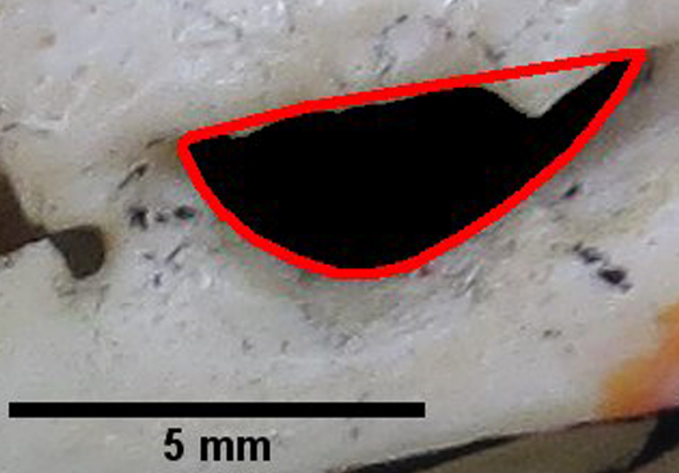

In [12]:
#@title Solidez, contorno convexo.
Image("/content/drive/MyDrive/mentoria/Img_aux/solidez.png",width = 200, height = 150)


Rta: No se descartaria en principio los datos de solidez, podemos mantenerlo como una valiable aleatoria mas a considerar en cada muestra. Es posible que la solidez correlacione con otras variables (ej: redondez, circularidad). Con suficientes evidencias se puede respaldar la decisión de definir si tiene o no sentido considerar este atributo. En todo caso el aporte de información no será significativo.

Luego idetificamos un conjunto de columnas que hace referencia a coordenadas posicionales del objeto. Esas coordinas pueden ser descartadas del análisis, ya que no forman parte de la descripción topológica una una tumoesfera. Se descartan en la celda de abajo.

In [13]:
# Descarte de las columnas con información posicional.
cols_descartar = ['X', 'Y', 'XM', 'YM', 'BX', 'BY', 'FeretX', 'FeretY', 'FeretAngle']
fiji_datos.drop(cols_descartar, axis=1, inplace=True)

### Respuesta a la consigna 2):

In [14]:
# Asignación de nuevos nombres a las columnas que se mantienen
asig_nombres_cols = {
    'labels': 'nombre_id',
    'Area': 'area',
    'Perim.': 'perimetro',
    'Width': 'ancho',
    'Height': 'altura',
    'Circ.': 'circularidad',
    'Feret': 'feret',
    'MinFeret': 'min_feret',
    'AR': 'razon_aspecto',
    'Round': 'redondez',
    'Solidity': 'Solidity',
    'Esferoide': 'esferoide',
    'dia': 'dia',
    'Diameter': 'diametro',
    'n_diam': 'poblacion_celular'
}

fiji_datos.rename(columns=asig_nombres_cols, inplace=True)
fiji_datos.head()

,nombre_id,area,perimetro,ancho,altura,circularidad,feret,min_feret,razon_aspecto,redondez,Solidity,esferoide,dia,diametro,poblacion_celular
0,Esferas_BT474_dia_0_well_1_100X_1_blob_1,324.4440,67.3603,21.0598,19.7011,0.8985,22.2117,19.7011,1.0653,0.9387,0.9500,si,0,20.95640,1.491357
1,Esferas_BT474_dia_0_well_1_100X_1_blob_2,497.5115,82.8004,25.8152,25.1359,0.9119,26.8751,25.1289,1.0475,0.9546,0.9569,si,0,26.00200,2.848733
2,Esferas_BT474_dia_0_well_1_100X_1_blob_3,282.9078,62.1586,19.7011,18.3424,0.9201,20.4370,18.3424,1.0395,0.9620,0.9519,si,0,19.38970,1.181258
3,Esferas_BT474_dia_0_well_1_100X_1_blob_5,500.7421,84.5571,26.4946,25.1359,0.8801,26.6336,25.1359,1.0278,0.9730,0.9493,si,0,25.88475,2.810370
4,Esferas_BT474_dia_0_well_1_100X_1_blob_6,492.8964,82.0728,25.1359,24.4565,0.9195,26.2232,24.4565,1.0186,0.9817,0.9643,si,0,25.33985,2.636596


Identificacion de datos Nulos

In [15]:
fiji_datos.isnull().sum()

nombre_id            0
area                 0
perimetro            0
ancho                0
altura               0
circularidad         0
feret                0
min_feret            0
razon_aspecto        0
redondez             0
Solidity             0
esferoide            0
dia                  0
diametro             0
poblacion_celular    0
dtype: int64

Se confirma que el set de datos no contiene valores nulos, con lo cual al menos en esta instancia no necesitamos hacer imputaciones o eliminar datos. Se recibe un dataset con información de calidad en cuanto a la consistencia de tipos de datos y contenido de información.

### Respuesta a la consigna 3) a):

¿Se trata de una muestra o plobación?
- Consideramos que **se trata de una muestra**, porque analizando las imágenes crudas que contienen todos los elementos discretos (esta sería la población), se han seleccionado mediante cortes solo algunos de los elementos. Incluso en los distintos días tenemos diferentes números de muestras seleccionadas.


### Respuesta a la consigna 3) b):

¿Es mas probable que sea esferoide que no lo sea?

- Del cálculo de la proporción de esferoides se concluye que si se selecciona un dato de la muestra **no hay mayor probabilidad que sea esferoide**.


In [16]:
esferoides_si = fiji_datos[fiji_datos['esferoide'] == 'si']
proporcion_esferoides = len(esferoides_si) / len(fiji_datos)
print(f'La proporción de esferoides es {round(proporcion_esferoides,2)}')

La proporción de esferoides es 0.51


### Respuesta a la consigna 3) c) y d):

¿La forma (área, circularidad, diámetro, redondez) influye en la clasificación de Esferoide?

¿Tales variables son independientes entre sí?

- Realizamos para cada una de esas variables un violin plot, separando por esferoide 'si' y 'no', y analizamos las formas de los violines resultantes. Si de manera cualitativa se observan formas distintas **se puede asumir que esas variables influyen en la clasificación**.

- De ese análisis (abajo) se observa que los violines son diferentes entres sí, con lo cual se puede decir que esas variables si pueden determinar la clasificación de esferoide 'si' y 'no'. En particular las variables asociadas 'shape' (circularidad y redondez) parecen ser como mas discriminadoras, con colas en los violines que son significativamente diferentes.

- Para analizar la dependencia entre estas variables se pude utilizar la función *corr* de pandas y graficar la matriz de correlación intervariable. De la tabla de correlaciones (ver celda mas abajo) se observa una alta correlación entre el diámetro y el área (r=0.96). Esto tiene sentido, dado que el area de una circunsferencia depende el radio (A = $\pi$ r<sup>2</sup>), siendo el radio <- 1/2 diámetro. Hay algún grado de paralelismo entre la circularidad y redondez (r=0.69), aunque no estan estrechamente relacionadas. Estaría bueno ver como se calculan estos parámetros, que por a primera impresión debería dar más o menos lo mismo.


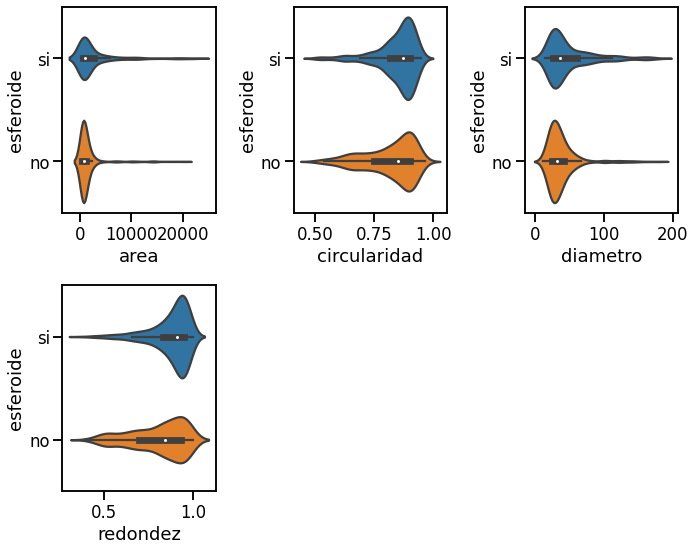

In [17]:
# Obtención de los violines para los grupos esferoides 'si'y 'no'
columns_of_interest = ['area','circularidad','diametro','redondez']

fig = plt.figure(figsize=(10,8))

c = 1
for column in columns_of_interest:
    plt.subplot(2, 3, c)
    sns.violinplot(y=fiji_datos['esferoide'], x=fiji_datos[column])
    c += 1

plt.tight_layout()

In [18]:
# Evaluar independencia entre estas variables
columns_of_interest = ['area','circularidad','diametro','redondez']
selected_df = fiji_datos[columns_of_interest]
correlation = selected_df.corr()
correlation.style.background_gradient(cmap='coolwarm')


,area,circularidad,diametro,redondez
area,1.000000,-0.273546,0.957783,0.010173
circularidad,-0.273546,1.000000,-0.392000,0.695366
diametro,0.957783,-0.392000,1.000000,-0.073744
redondez,0.010173,0.695366,-0.073744,1.000000


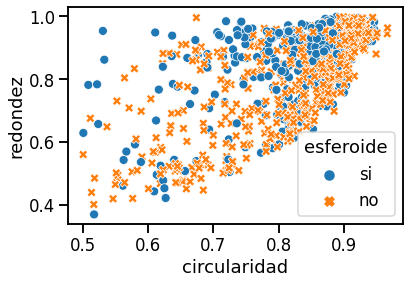

In [19]:
sns.scatterplot(x='circularidad', y='redondez', data=fiji_datos, hue='esferoide', style='esferoide')


#### Correlación positiva entre Solidez y circularidad, evidencia.

              Solidity  circularidad
Solidity          1.00          0.81
circularidad      0.81          1.00


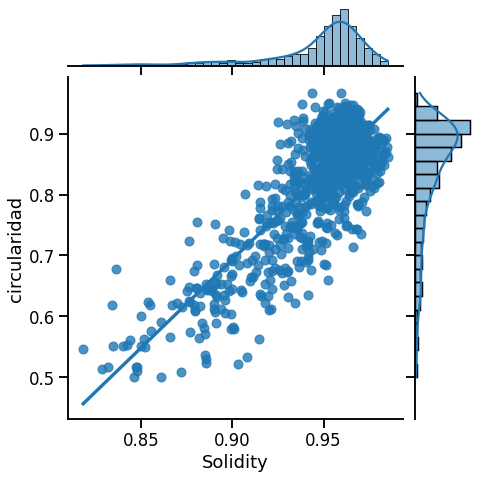

In [20]:
sns.jointplot(x='Solidity', y='circularidad', data=fiji_datos, 
              kind='reg',
              joint_kws={'ci':None, 'order':1}, # orden 1=lineal..
              size=7,
             )
correla_var = fiji_datos[['Solidity', 'circularidad']].corr()
print(round(correla_var,2))

#### Correlación entre Solidez y redondez, evidencia.

          Solidity  redondez
Solidity      1.00      0.63
redondez      0.63      1.00


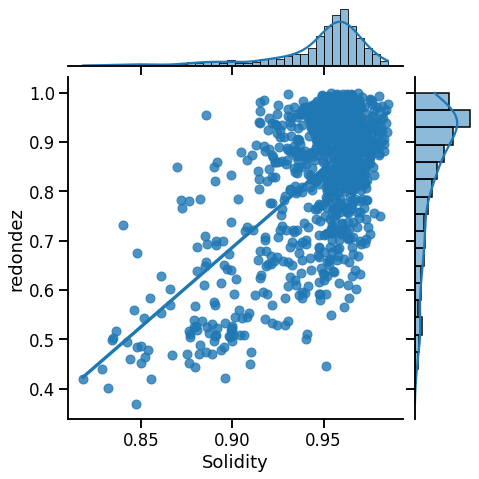

In [21]:
sns.jointplot(x='Solidity', y='redondez', data=fiji_datos, 
              kind='reg',
              joint_kws={'ci':None, 'order':1}, # orden 1=lineal..
              size=7,
             )
correla_var = fiji_datos[['Solidity', 'redondez']].corr()
print(round(correla_var,2))

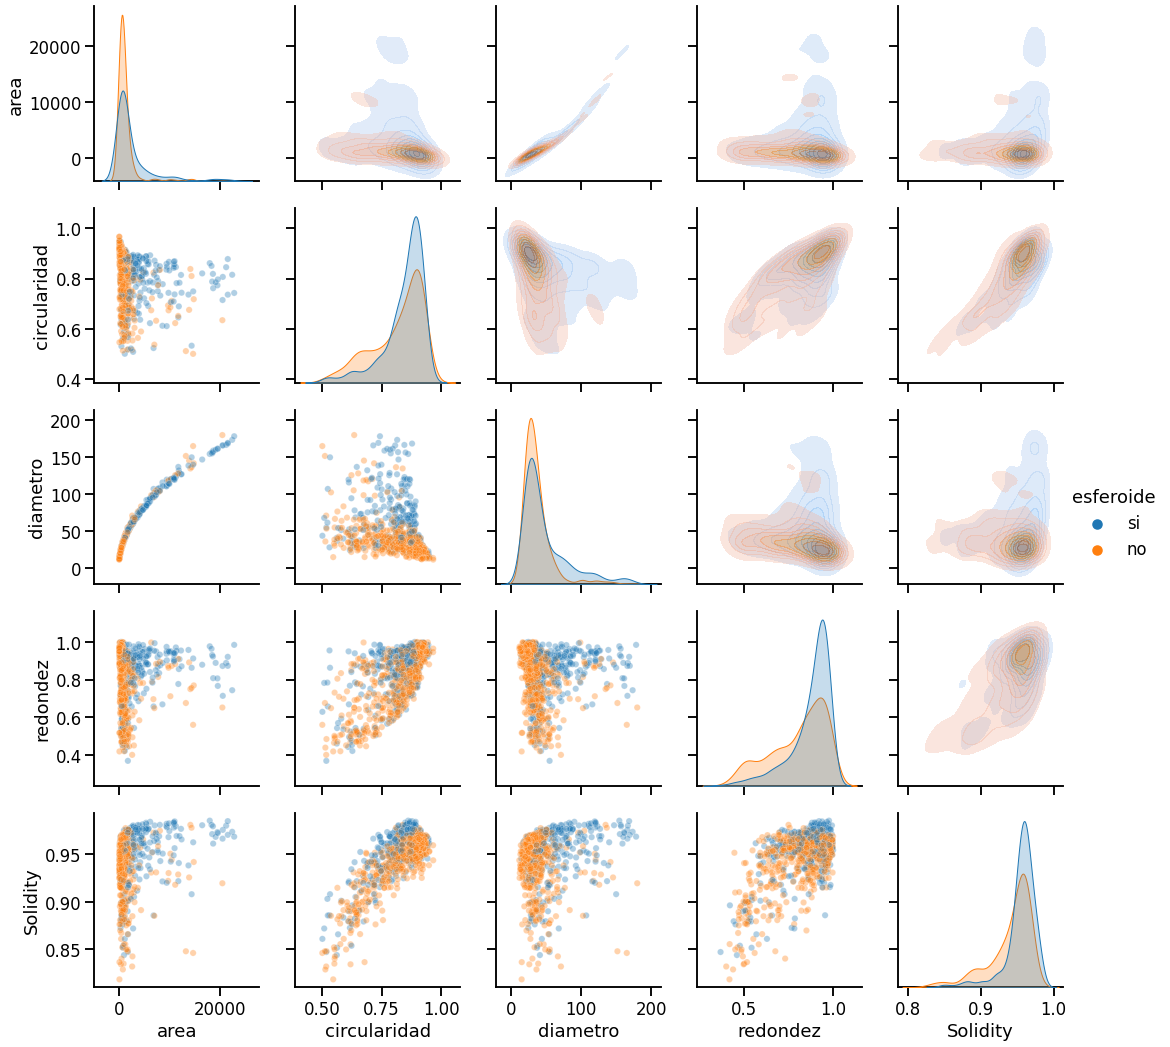

In [22]:
var_list=['area', 'circularidad', 'diametro', 'redondez', 'Solidity']
# Se observa correlación (0.96) entre el diámetro y el área 
# Se observa correlación (0.81) entre la circularidad y la solidez
# Se observa correlación (0.69) entre la circularidad y la redondez
# Se observa correlación (0.63) entre la solidez y la redondez

g = sns.PairGrid(fiji_datos, hue='esferoide', diag_sharey=False, vars=var_list, height=3, aspect=1)
g.map_upper(sns.kdeplot,fill=True, lw=1, alpha=0.35)
g.map_diag(sns.kdeplot, fill=True, lw=1)
g.map_lower(sns.scatterplot, s=40, alpha=0.35)
g.add_legend();

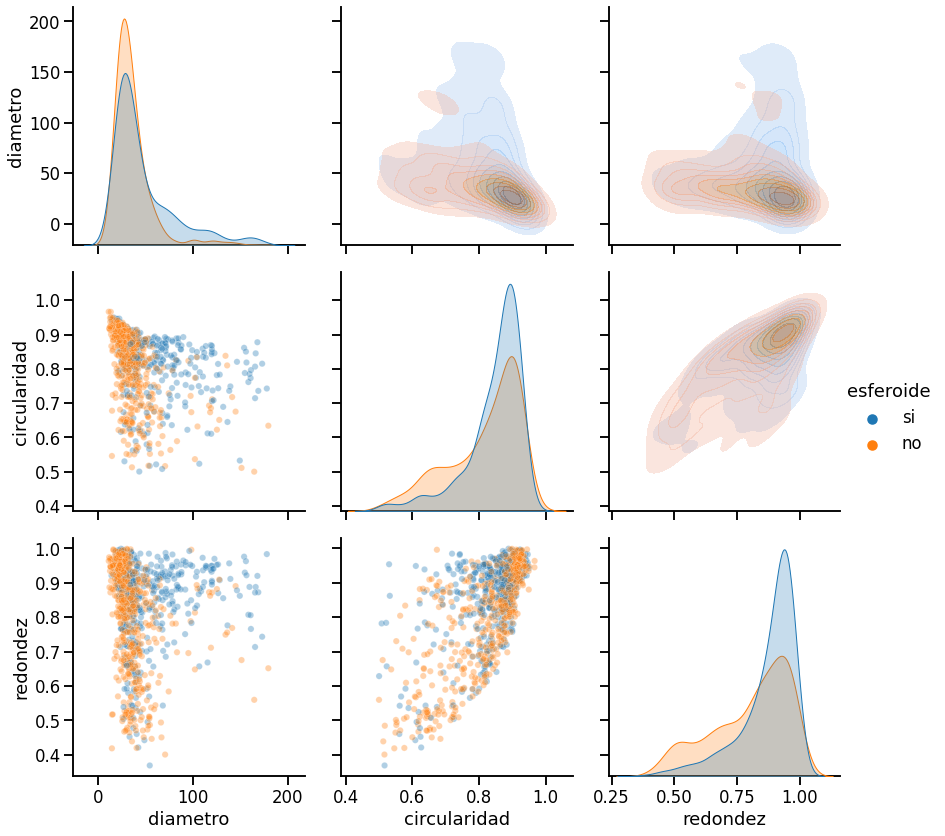

In [23]:
var_list=['diametro','circularidad','redondez']
g = sns.PairGrid(fiji_datos, hue='esferoide', diag_sharey=False, vars=var_list, height=4, aspect=1)
g.map_upper(sns.kdeplot,fill=True, lw=1, alpha=0.35)
g.map_diag(sns.kdeplot, fill=True, lw=1)
g.map_lower(sns.scatterplot, s=40, alpha=0.35)
g.add_legend();


### Respuesta a la consigna 3) e):

¿La probabilidad de que la redondez ('Round') sea mayor a 0.9 en los clasificados como *Esferoides* = **si** es mayor que los clasificados como *Esferoides* = **no**?.

- El cálculo de probabilidad muestra que si la *redondez* es mayor a 0.9, la probabilidad que se esferoide *si* (prob:0.62) es mayor a que sea esferoide *no*.

In [24]:
above_redondez_cuttof = fiji_datos[fiji_datos['redondez'] >= 0.9]
esferoides_si_sobre_cuttoff = above_redondez_cuttof[above_redondez_cuttof['esferoide'] == 'si']
probabilidad_interes = len(esferoides_si_sobre_cuttoff) * 1 / len(above_redondez_cuttof)
probabilidad_interes

0.6252676659528907

### Respuesta a la consigna 4) a):

¿Cuántos datos hay por día? Hacer gráfico de frecuencias.

Respuesta: se observa una catidad variable de datos por día, siendo mas numerosa el día 1 que el resto de los días. Se identifica un día con características anómalas (día 6), en donde la cantidad de muestras es muy bajo. Siendo un cultivo celular una sistema de evolución contínua, es llamativo que el día 7 se tomaron muestras en un número similar al de días anteriores. **Es posible que en el día 6 sucediera un problema con el microscopio invertido o la toma de la foto, y se descarta problema en el sistema celular.**

In [25]:
# Cantidad de datos por día
fiji_datos['dia'].value_counts()[[0,1,2,3,4,5,6,7]]

0     94
1    342
2    155
3     43
4    254
5     52
6      4
7     74
Name: dia, dtype: int64

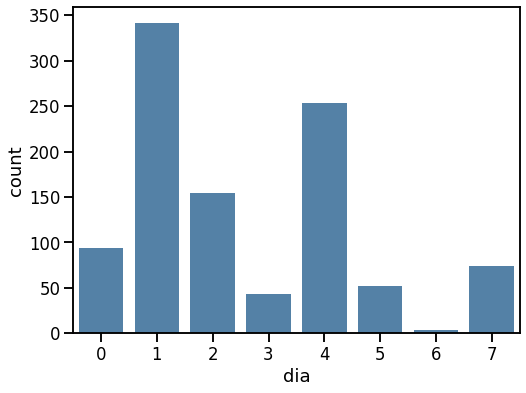

In [26]:
# Gráfico de frecuencias de la cantidad de datos por día
fig = plt.figure(figsize=(8,6))
sns.countplot(fiji_datos.dia, color='steelblue')
plt.xticks(rotation=0)
plt.show()

### Respuesta a la consigna 4) b):

Explorar con diagramas de cajas al menos una columna (ej. Diameter/n_diam pero pueden animarse a más).

Aquí abajo se explora mediante un boxplot la distribución de las mediciones de 'diámetro' en los distintos días. Cabe destacar que este gráfico solo muestras distribución conjunta de esferoides 'si' y 'no', con lo cual hay que considera que distribuciones con alto 'skewness' pueden ser indicativos de un potencial para discriminar esferas 'si' y 'no' si se toma una aproximación de separar ambos subgrupos.

De este gráfico de boxplot se observa que **la kurtosis aumenta prograsivamente hacia el día 3, 4 y 5**, disminuyendo luego. Si este aumento de kurtosis para el conjunto combinado de esferoides 'si'/'no' implica una separación del diámetro entre los grupos, estamos en un buen escenario descriptivo para la variable 'diámetro'. Lo analizaremos mas adelante!

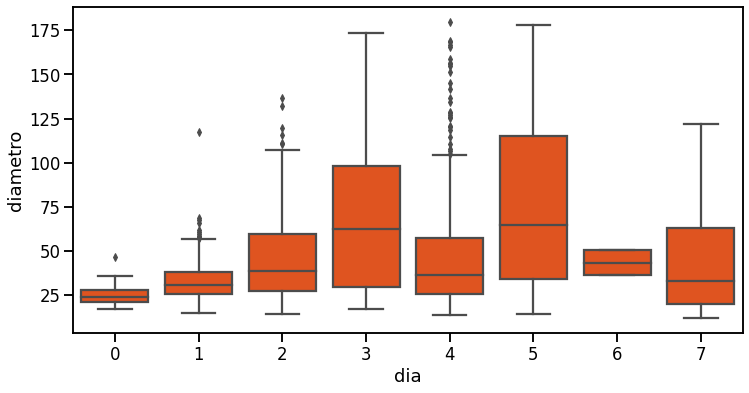

In [27]:
# Boxplot diametro para el total por día
plt.figure(figsize=(12, 6))
sns.boxplot(data=fiji_datos, x='dia', y='diametro',
                color='orangered')
#plt.ticklabel_format(style='plain', axis='x')

Acá abajo inspeccionado la variable que describe el patrón del **crecimiento celular**. Esa variable está originalmente llamada "población celular", y se calcula como el cubo del cociente entre el diámetro al día *n* y el diámetro mínimo al día cero (esto sería como la linea de base de diámetros para computar un crecimiento celular). Lo primero que sería de destacar es que el nombre de la variable no es cualitativamente asociable a lo que describe: lo llamaríamos algo así como "ratio de crecimiento" en lugar de "población celular". No la renombramos para mantener consistencia con análisis previos reportados.

Del boxplot extraemos una conclusión consistente con el boxplot anterior: "***Las formaciones celulares crecen, con un skewness máximo a día 4***". Esto sugiere la posibililidad que en día 4 se observen mas nítidamente las diferencias asociadas a crecimiento entre los grupos esferoides si/no. Se enfoca en análisis mas adelante. 

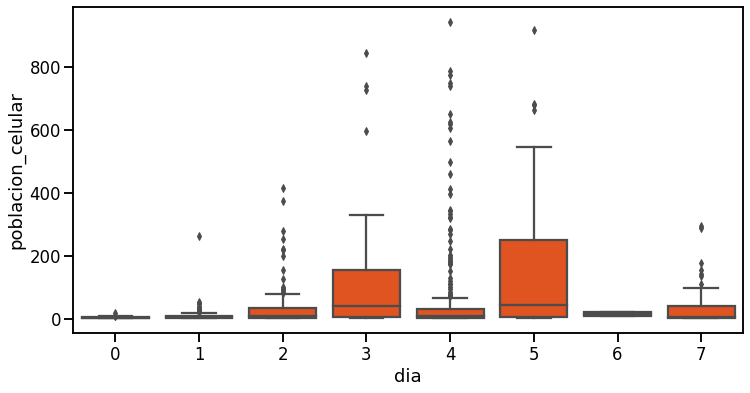

In [28]:
# Boxplot poblacion_celular para el total por día
plt.figure(figsize=(12, 6))
sns.boxplot(data=fiji_datos, x='dia', y='poblacion_celular',
                color='orangered')
#plt.ticklabel_format(style='plain', axis='x')

### Respuesta a la consigna 4) c):

Discriminar la(s) columna(s) elegida(s) en Esferoide 'si' y 'no' y ver sus distribuciones. ¿Son distintas?. Describirlas (asimetría, kurtosis, etc..) Determinen el intervalo de confianza diario de tal(es) columna(s) para las clasificadas como 'Esferoide'='si'. Y si animan utilizarlos como barras de error en el gráfico.

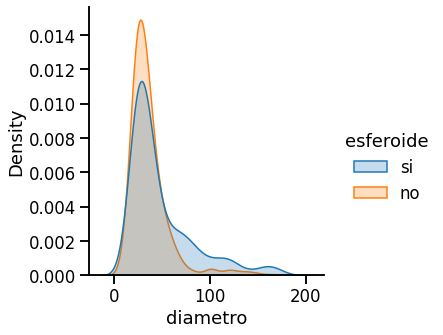

In [29]:
# Distribución del diametro para Esferoide 'si' y 'no'
sns.displot(fiji_datos, x="diametro", hue="esferoide", kind="kde", fill=True)

Se observa que ambas distribuciones son asimétricas a derecha. Se observa un 'skewness' hacia la derecha mayor para el conjunto de "esferoide si". Dado que este gráfico es conjunto para todos los días, es interesante profundizar si este desplazamiento se produce como consecuencia de mediciones en un día particular.

In [30]:
# Kurtosis diámetro para esferoides 'si'
kurtosis(fiji_datos[fiji_datos.esferoide=='si'].diametro)

2.613932103211722

In [31]:
# Kurtosis diámetro para esferoides 'no'
kurtosis(fiji_datos[fiji_datos.esferoide=='no'].diametro)

11.23549807817478

La distribución del diámetro para esferoide 'no' posee mayor kurtosis que la distribución del diámetro para esferoide 'sí', lo cual es indicativo de una mayor concentración de las muestras en el grupo 'esferoide no'.

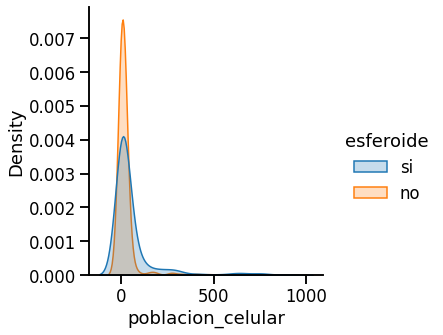

In [32]:
# Distribución del poblacion_celular para Esferoide 'si' y 'no'
sns.displot(fiji_datos, x="poblacion_celular", hue="esferoide", kind="kde", fill=True)

Se observa que ambas distribuciones son asimétricas a derecha. La distribución de esferoide 'no' posee un pico más pronunciado que la distribución de esferoide 'si'.


#### Evolución comparativa del diámetro de Esferoides si/no por día.

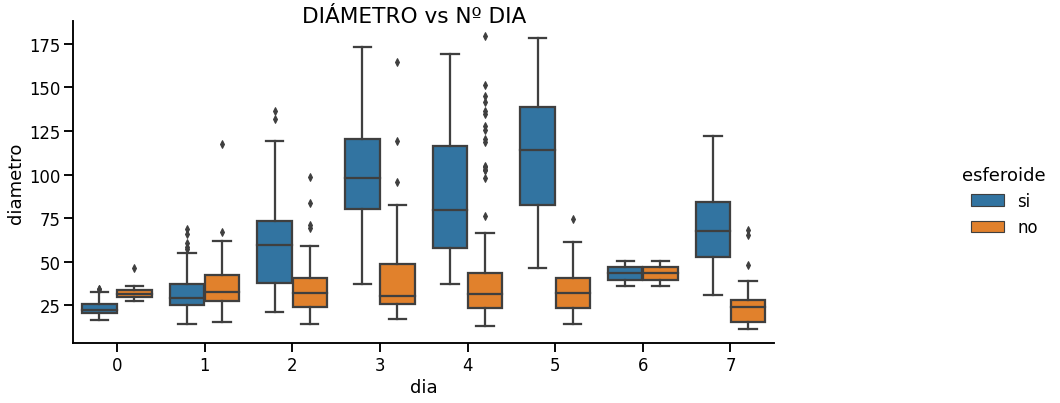

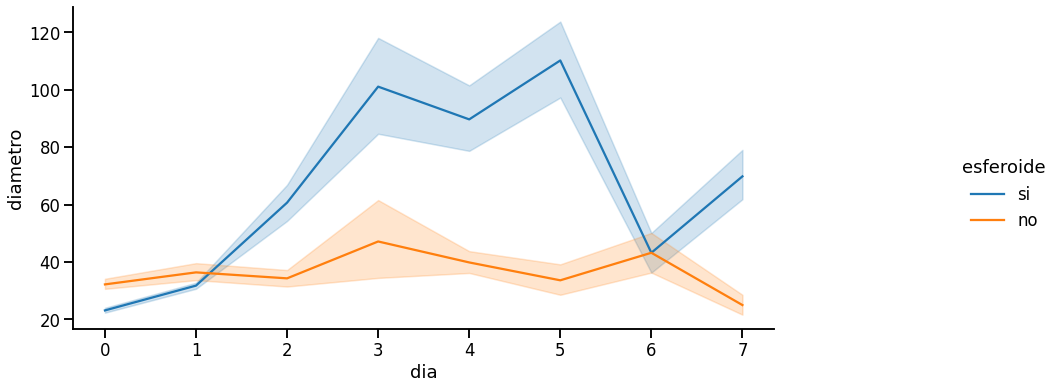

In [33]:
# Diagrama de cajas
g= sns.catplot(x='dia', y='diametro', 
            data=fiji_datos, 
            hue='esferoide',
            kind='box');
g.fig.suptitle('DIÁMETRO vs Nº DIA')
g.fig.set_size_inches(18,6)

# Diagrama relacional(bootstraping en seaborn) link explicativo= https://www.youtube.com/watch?v=CMRVEKf9jWA
g=sns.relplot(x='dia', y='diametro', 
            data=fiji_datos, 
            hue='esferoide',
            kind='line');
g.fig.set_size_inches(18,6)

##### **Observaciones:**
  - Desde el dia 0 al 5 se observa el crecimiento del diámetro en los esferoides "si". Sin embargo los esferoides "no" mantienen medidas de posición y dispersión "mas estables".

  - Confirmando lo que analizamos cuando contamos los datos, en el día 6 se produce una situación anómala de baja toma de muestras.


##### **Graficos complementarios:**
  - Circularidad, Redondez y Solidez de Esferoidez (Si/No), evolución por día.

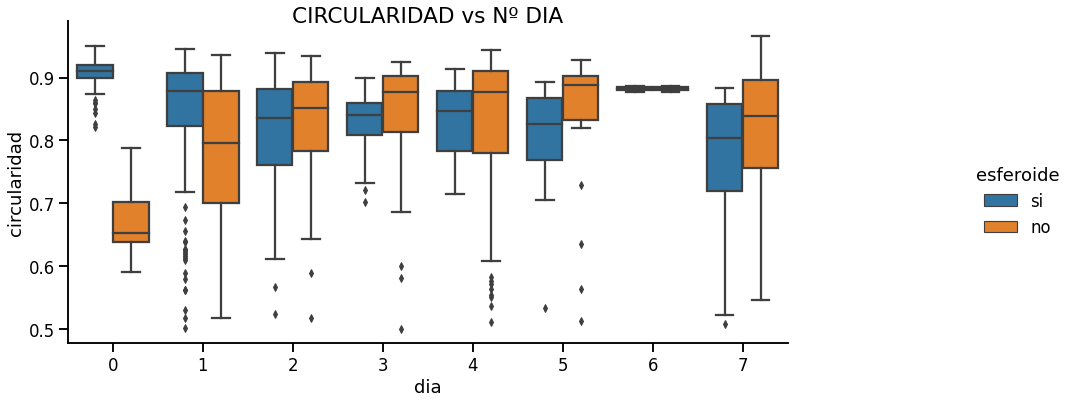

In [34]:
# Stack de diagramas de cajas

g= sns.catplot(x='dia', y='circularidad', 
            data=fiji_datos, 
            hue='esferoide',
            # palette="Blues",
            kind='box');
g.fig.suptitle('CIRCULARIDAD vs Nº DIA')
g.fig.set_size_inches(18,6)

##### Los esferoides "no" exponen mayor **circularidad** desde el día dos al cinco con una mediana creciente y superior a la correspondiente a esferoides "si" quienes mantienen una mediana "estable" para el mismo periodo de estudio.

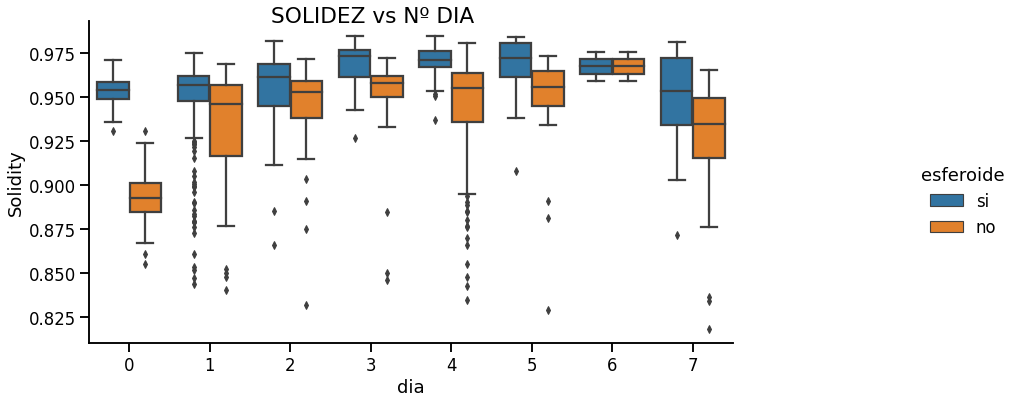

In [35]:
g= sns.catplot(x='dia', y='Solidity', 
            data=fiji_datos, 
            hue='esferoide',
            kind='box');
g.fig.suptitle('SOLIDEZ vs Nº DIA')
g.fig.set_size_inches(18,6)

##### Los esferoides "si" poseen una **solidiez** superior a los esferoides "no". La solidez de los esferoides crece y se consolidad en el día cinco.

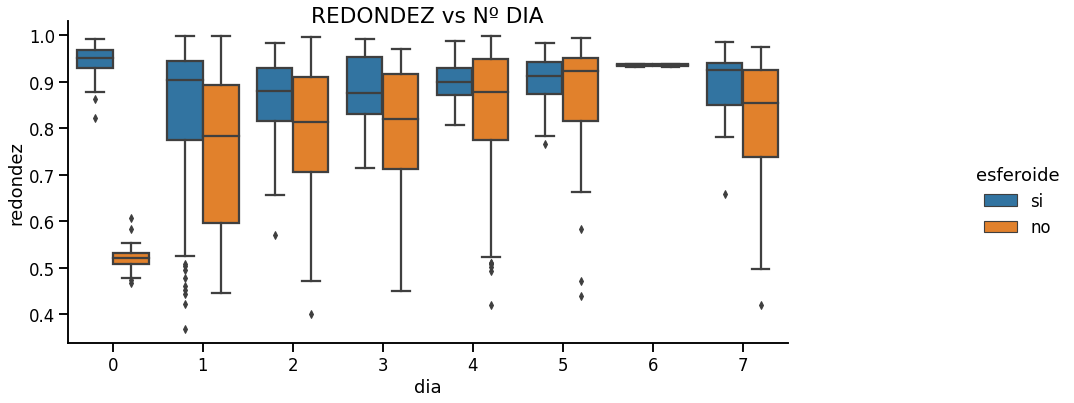

In [36]:
g= sns.catplot(x='dia', y='redondez', 
            data=fiji_datos, 
            hue='esferoide',
            kind='box');
g.fig.suptitle('REDONDEZ vs Nº DIA')
g.fig.set_size_inches(18,6)

##### Los esferoides "si" poseen una **redondez** superior a los esferoides "no", la cual crece con el paso de los dias redudiciendo su varianza relativa. 

##### **Cálculo de intervalos de confianza para díametro por día esferoides 'si'**

A continuación vamos a calcular los intervalos de confianza para díametro por día para esferoide 'si'.

El intervalo de confianza está dado por
$$[\overline{x}-t_{n-1,\alpha/2}EE;\overline{x}+t_{n-1,\alpha/2}EE],$$
donde $EE$ es el error estándar, es decir
$$EE=\frac{s}{\sqrt{n}}.$$

In [37]:
# Medidas resumen para diámetro por día para esferoide 'si'
df_des = fiji_datos[fiji_datos.esferoide=='si'].groupby('dia')
df_des['diametro'].describe()

,count,mean,std,min,25%,50%,75%,max
dia,,,,,,,,
0,74.0,23.145003,3.706282,16.78015,20.385750,22.308175,25.781875,34.53205
1,253.0,31.781506,8.828702,14.45690,25.241600,29.106850,37.387450,68.57405
2,70.0,60.685558,26.791912,21.06495,37.710962,59.566525,73.272300,136.72490
3,18.0,101.092311,37.918587,37.27645,80.144275,98.014225,120.282212,173.24380
4,48.0,89.688273,41.278661,37.06580,57.732788,79.730225,116.138750,169.18725
5,28.0,110.212304,35.374617,46.61540,82.360275,113.879650,138.836575,178.15910
6,2.0,43.221100,9.764013,36.31690,39.769000,43.221100,46.673200,50.12530
7,29.0,69.835909,24.229859,30.60805,52.462000,67.860450,84.485900,122.03085


In [38]:
# Cálculo de t_{n-1;apha/2}
t0=scipy.stats.t(df=73).ppf(0.975)
t1=scipy.stats.t(df=252).ppf(0.975)
t2=scipy.stats.t(df=69).ppf(0.975)
t3=scipy.stats.t(df=17).ppf(0.975)
t4=scipy.stats.t(df=47).ppf(0.975)
t5=scipy.stats.t(df=27).ppf(0.975)
t6=scipy.stats.t(df=1).ppf(0.975)
t7=scipy.stats.t(df=28).ppf(0.975)
t=[t0,t1,t2,t3,t4,t5,t6,t7]
t

[1.9929971255321663,
 1.9694223653655463,
 1.9949454146328136,
 2.1098155778331806,
 2.0117405104757546,
 2.0518305164802833,
 12.706204736432095,
 2.048407141795244]

In [39]:
# Vector de medias diámetro para esferoides 'si'
df_esferoide_si = fiji_datos[fiji_datos.esferoide=='si']
m0=df_esferoide_si[df_esferoide_si.dia==0].diametro.mean()
m1=df_esferoide_si[df_esferoide_si.dia==1].diametro.mean()
m2=df_esferoide_si[df_esferoide_si.dia==2].diametro.mean()
m3=df_esferoide_si[df_esferoide_si.dia==3].diametro.mean()
m4=df_esferoide_si[df_esferoide_si.dia==4].diametro.mean()
m5=df_esferoide_si[df_esferoide_si.dia==5].diametro.mean()
m6=df_esferoide_si[df_esferoide_si.dia==6].diametro.mean()
m7=df_esferoide_si[df_esferoide_si.dia==7].diametro.mean()
m=[m0,m1,m2,m3,m4,m5,m6,m7]
m

[23.145003378378384,
 31.781505731225305,
 60.68555785714286,
 101.0923111111111,
 89.68827291666666,
 110.21230357142859,
 43.2211,
 69.83590862068966]

In [40]:
# Vector Error estándar para diémetro esferoide 'si'
e0 = df_esferoide_si[df_esferoide_si.dia==0].diametro.std()/math.sqrt(74)
e1 = df_esferoide_si[df_esferoide_si.dia==1].diametro.std()/math.sqrt(253)
e2 = df_esferoide_si[df_esferoide_si.dia==2].diametro.std()/math.sqrt(70)
e3 = df_esferoide_si[df_esferoide_si.dia==3].diametro.std()/math.sqrt(18)
e4 = df_esferoide_si[df_esferoide_si.dia==4].diametro.std()/math.sqrt(48)
e5 = df_esferoide_si[df_esferoide_si.dia==5].diametro.std()/math.sqrt(28)
e6 = df_esferoide_si[df_esferoide_si.dia==6].diametro.std()/math.sqrt(2)
e7 = df_esferoide_si[df_esferoide_si.dia==7].diametro.std()/math.sqrt(29)
e=[e0,e1,e2,e3,e4,e5,e6,e7]
e

[0.43084655857792403,
 0.5550557374674313,
 3.2022460292260857,
 8.937496567355762,
 5.958061523765891,
 6.685174230791931,
 6.904200000000002,
 4.499371800024844]

In [41]:
# Vector error para diámetro esferoides 'si'
c = [a * b for a, b in zip(t, e)]
c

[0.8586759527912288,
 1.0931391833928263,
 6.388306032530714,
 18.856469484637763,
 11.986073731266746,
 13.71684449472649,
 87.7261787412745,
 9.216545328763013]

Text(0, 0.5, 'Diámetro medio')

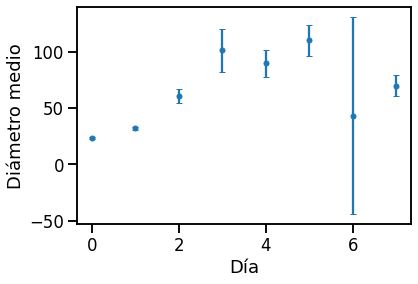

In [42]:
# Gráfico de medias e intervalos de confianza por día para diámetro esferoides 'si'
dias = [0, 1, 2, 3, 4, 5, 6, 7]
plt.figure()
plt.errorbar(dias, m, yerr=c, fmt = 'o',capsize=3,markersize=5)
plt.xlabel("Día")
plt.ylabel("Diámetro medio")

El intervalo de confianza para el día 6 es muy grande porque hay pocos datos para ese día.

#### Evolución comparativa de poblacion_celular de Esferoides si/no por día.

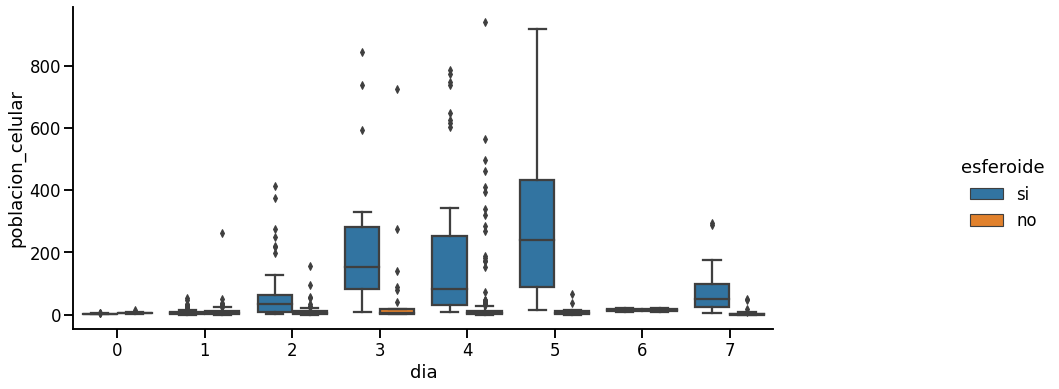

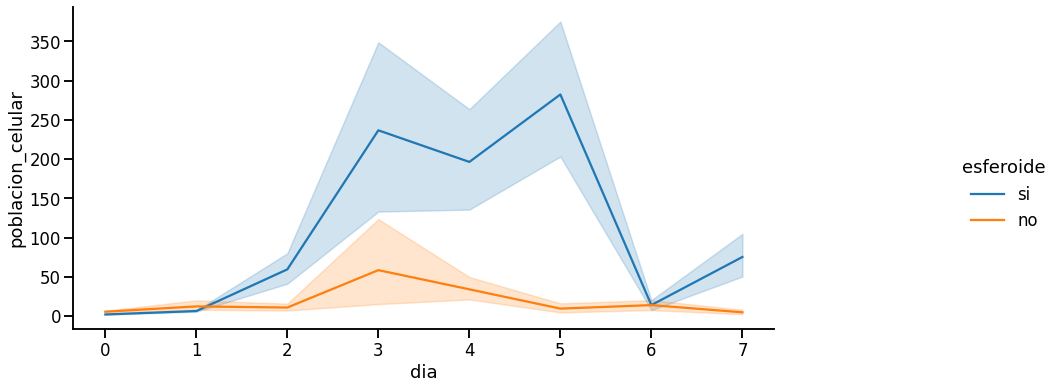

In [43]:
# Diagrama de cajas
g= sns.catplot(x='dia', y='poblacion_celular', 
            data=fiji_datos, 
            hue='esferoide',
            kind='box');
g.fig.set_size_inches(18,6)

# Diagrama relacional(bootstraping en seaborn) link explicativo= https://www.youtube.com/watch?v=CMRVEKf9jWA
g=sns.relplot(x='dia', y='poblacion_celular', 
            data=fiji_datos, 
            hue='esferoide',
            kind='line');
g.fig.set_size_inches(18,6)

##### **Observaciones:**

* Se observa que la población celular para esferoides 'si' 
crece a partir del día 1. En cambio la población celular para los casos clasificados como esferoides 'no' se mantiene constante.

* En el día 6 ocurre la misma anomalía que para la variable diámetro. 

### Respuesta a la consigna 4) d):

¿Hay outliers? Hacer con el total y luego discriminando por Esferoide' si y no. ¿Qué pueden implicar biológicamente? Si los eliminan, ¿cuál sería la justificación?

Si identifican un par, traten de determinar el 'nombre_id' y las buscamos en las imágenes.

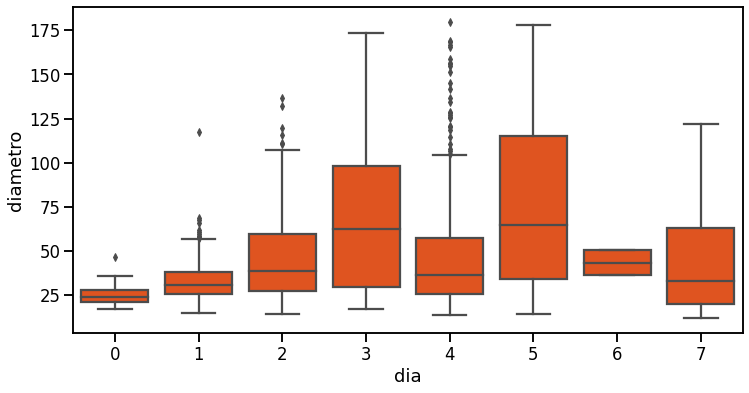

In [44]:
# Boxplot díametro para el total por día
plt.figure(figsize=(12, 6))
sns.boxplot(data=fiji_datos, x='dia', y='diametro',
                color='orangered')
#plt.ticklabel_format(style='plain', axis='x')

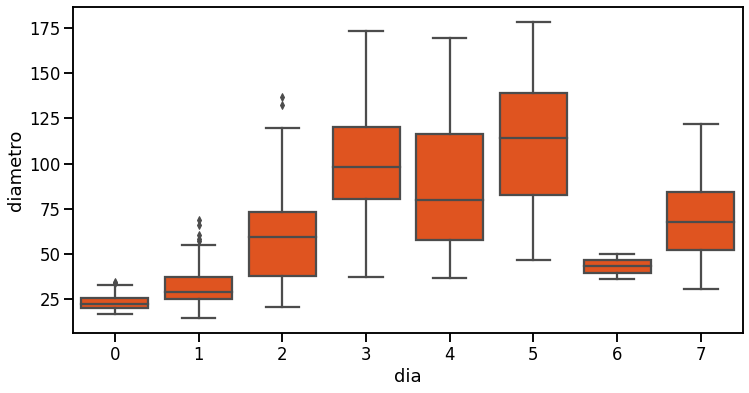

In [45]:
# Boxplot díametro para Esferoide 'si' por día
plt.figure(figsize=(12, 6))
sns.boxplot(data=fiji_datos[fiji_datos.esferoide=='si'], x='dia', y='diametro',
                color='orangered')
#plt.ticklabel_format(style='plain', axis='x')

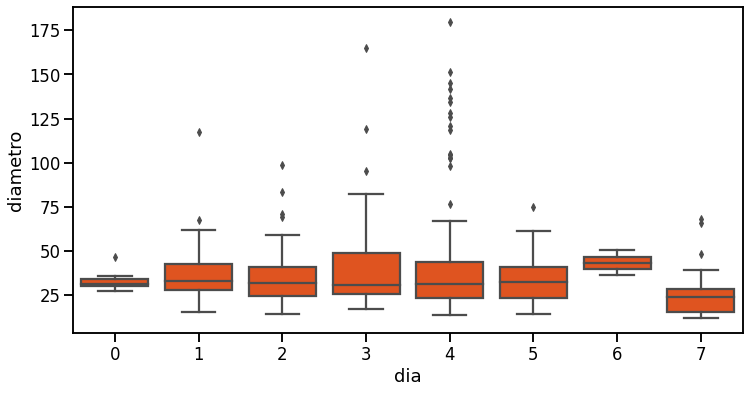

In [46]:
# Boxplot díametro para Esferoide 'no' por día
plt.figure(figsize=(12, 6))
sns.boxplot(data=fiji_datos[fiji_datos.esferoide=='no'], x='dia', y='diametro',
                color='orangered')
#plt.ticklabel_format(style='plain', axis='x')

- Para la variable diámetro, sin discriminar por esferoide si/no, se observan muchos outliers en los días 0, 1, 2 y 4. Cabe destacar que aquí el concepto de 'outlier' puede significar incluso un escenario positivo para discriminar entre esferoide si/no, dado que hay muchos datos extremos cuando se toman en su conjunto.

- Cuando se discrimina por esferoide si/no, **se observan diámetros mayores que para el conjunto 'si' que para el conjunto 'no'**. Esto tienen consistencia con el background biológico: "se espera que una tumoresfera crezca a partir de la un única cancer stem cell, y lo haga con una matriz homogénea". Para los esferoide 'si', hay pocos outliers en los días 0, 1 y 2, mientras que no hay outlier es los días más favorables a la descripción de la tumoresfera, que son los días 4 y 5.

- En el caso esferoide 'no' hay muchos outliers en casi todos los días. Desde el plano del análisis del significado biológico, y teniendo en cuenta que los outliers de esferoide 'no' son hacia valores altos de diámetros, se asume una cantidad creciente de agrupaciones cululares que no son derivadas de una única cancer stem cell, y que por lo tanto tienen diámetro grande, pero claramente se identifican con esferoide 'no'. El aumento de ouliers hacia el día 4 indica que este día de evolución del cultivo celular es adecuado para discriminar esferoides 'no' por dos causas: a) no crecieron (están dentro del IQR para a diámetros menores); b) se formaron acúmulos celular no esferoides (estructura de diámetro grande, pero que no se visibilizan como homogéneas y se marcan 'no'). Entonces: **para el conjunto de esferoides 'no', eliminar outliers se justifica en términos de eliminar datos que corresponden a acúmulos celulares que no son de interés.**

**El día 4 parece ser el ideal para analizar las características geométricas diferenciales entre esferoides si/no.**

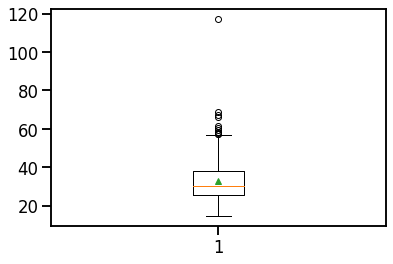

In [47]:
# Boxplot para diámetro día 1 sin discriminar por esferoide
bp = plt.boxplot(fiji_datos[fiji_datos.dia==1].diametro, showmeans=True)
plt.show()

In [48]:
# Outliers para diámetro sin discriminar por esferoide día 1
[item.get_ydata() for item in bp['fliers']]

[array([ 60.49185,  68.57405,  58.55705,  57.16815,  65.9901 ,  61.7462 ,
         67.1492 , 117.2965 ,  57.22035,  57.85435,  59.66755])]

In [49]:
# Identificación de un outlier esferoide 'no' día 1 para diámetro
df_outlier=fiji_datos[fiji_datos.diametro==117.2965]
df_outlier

,nombre_id,area,perimetro,ancho,altura,circularidad,feret,min_feret,razon_aspecto,redondez,Solidity,esferoide,dia,diametro,poblacion_celular
408,Esferas_BT474_dia_1_well_1_100X_1_blob_52,9721.7812,419.8749,122.962,112.0924,0.693,128.9276,105.6654,1.1457,0.8728,0.9219,no,1,117.2965,261.509024


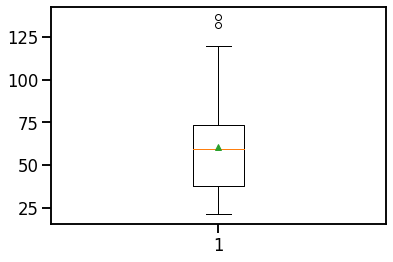

In [50]:
# Boxplot para diámetro día 2 esferoide 'si'
bp = plt.boxplot(fiji_datos[fiji_datos.esferoide=='si'][fiji_datos.dia==2].diametro, showmeans=True)
plt.show()

In [51]:
# Outliers para diámetro esferoide 'si' día 2
[item.get_ydata() for item in bp['fliers']]

[array([136.7249, 132.1722])]

In [52]:
# Identificación de un outlier esferoide 'si' día 2 para diámetro
df_outlier=fiji_datos[fiji_datos.diametro==136.7249]
df_outlier

,nombre_id,area,perimetro,ancho,altura,circularidad,feret,min_feret,razon_aspecto,redondez,Solidity,esferoide,dia,diametro,poblacion_celular
449,Esferas_BT474_dia_2_well_2_100X_4_blob_9,11736.749,478.1106,150.8152,118.2065,0.6452,157.3537,116.0961,1.288,0.7764,0.9216,si,2,136.7249,414.165923


### Respuesta a la consigna 4) e):

Interpretar lo que ven en los gráficos en términos generales. ¿Qué creen que sucedió a partir del día 6?

**Respuesta:** luego del EDA y combinando con conclusiones derivadas de intercambio técnico con el experto de dominio (Luciano), se observa en términos generales:
- Hacia el día 4 el tag de esferoide 'si' es mas confiable en término de asociarlo a mediciones topológicas que el día 0 y 1.
- Los elementos celulares asociados a esferoide 'si' demuestran crecimiento máximo hasta los días 4 y 5, luego los elementos identificados como esferoide 'si' tienen tamaños mas pequeños.
- El problema con el día 6 se percibe como un problema asociado al instrumento óptico (microscopio invertido) y no al sistema de cultivo celular. Esto es así porque los datos vuelven a ser normales el día 7.
- Para las variables díametro y población celular se observa un crecimiento diario hasta el día 5 para los casos clasificados como esferoide 'si'. Dicho comportamiento no se observa en los casos clasificados como esferoide 'no'. 

### Respuesta a la consiga 5):

¿Qué otras preguntas se pueden o quisieran plantear? (las que puedan y quieran, las responden, sino planteenlas nomás y las charlamos, quizás se las puede responder con otras herramientas o simplemente son interesantes para tenerlas en cuenta y sería lindo tener otra clase de datos para responderlas.)

DIA 6: Notar que en realidad existen muestras duplicadas. No se trata de 4 sino de dos evaluaciones. Posible error en la carga de datos.


In [53]:
 fiji_datos[fiji_datos['dia'] == 6].head()

,nombre_id,area,perimetro,ancho,altura,circularidad,feret,min_feret,razon_aspecto,redondez,Solidity,esferoide,dia,diametro,poblacion_celular
940,Esferas_BT474_dia_6_well_1_100X_11_blob_1,989.4849,119.0473,36.6848,37.3641,0.8774,38.2612,34.3726,1.0725,0.9324,0.9593,si,6,36.3169,7.761717
941,Esferas_BT474_dia_6_well_1_100X_12_blob_1,1871.4371,162.8552,48.2337,48.2337,0.8867,52.4684,47.7822,1.0654,0.9387,0.9758,si,6,50.1253,20.408095
942,Esferas_BT474_dia_6_well_1_100X_11_blob_1,989.4849,119.0473,36.6848,37.3641,0.8774,38.2612,34.3726,1.0725,0.9324,0.9593,no,6,36.3169,7.761717
943,Esferas_BT474_dia_6_well_1_100X_12_blob_1,1871.4371,162.8552,48.2337,48.2337,0.8867,52.4684,47.7822,1.0654,0.9387,0.9758,no,6,50.1253,20.408095


La muestra 940 y 941 son idénticas a las muestras 942 y 943 respectivamente. 

Se tienen una presunta inconsistencia. Muestras identicas han sido calificadas en un caso como esferoide SI y en el otro como esferoide NO.

